# Create a logistic regression model to predict RIT1 mutation from gene expression data in TCGA

In [1]:
import os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'RIT1' classifier 
GENE = '6016'# RIT1

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/RIT1) about RIT1*

## Load Data

In [4]:
%%time
path = os.path.join('..', 'download', 'expression-matrix.tsv.bz2')
X = pd.read_table(path, index_col=0)

CPU times: user 1min 10s, sys: 656 ms, total: 1min 10s
Wall time: 1min 10s


In [5]:
%%time
path = os.path.join('..', 'download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 41.3 s, sys: 248 ms, total: 41.5 s
Wall time: 41.5 s


In [6]:
y = Y[GENE]

In [7]:
# The Series now holds RIT1 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    0
TCGA-02-2483-01    0
TCGA-02-2485-01    0
TCGA-02-2486-01    0
TCGA-04-1348-01    0
Name: 6016, dtype: int64

In [8]:
# Here is the count of tumors with RIT1
y.value_counts()

0    7285
1      21
Name: 6016, dtype: int64

## Set aside 30% of the data for testing

In [9]:
# Typically, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))

'Size: 20,530 features, 5,114 training samples, 2,192 testing samples'

In [10]:
# Here is the count of tumors with RIT1 in the testing data
y_test.value_counts()

0    2186
1       6
Name: 6016, dtype: int64

## Preprocessing and noise reduction

In [11]:
scale_pre = StandardScaler()
X_train_scale = scale_pre.fit_transform(X_train)
X_test_scale = scale_pre.transform(X_test)

In [12]:
n_components = 30
pca = PCA(n_components=n_components, random_state=0)
X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

In [13]:
# Percentage of preserved variance
print('{:.4}'.format(sum(pca.explained_variance_ratio_)))

0.5824


In [14]:
scale_post = StandardScaler()
X_train_scale = scale_post.fit_transform(X_train_pca)
X_test_scale = scale_post.transform(X_test_pca)

## Parameters and Classifier Fitting

In [15]:
param_grid = {
    'alpha': [2**x for x in range(-20, 30)],
    'l1_ratio': [0, 0.05, 0.1, 0.15]
}

In [16]:
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.1, random_state=0)
clf = SGDClassifier(random_state=0, class_weight='balanced', loss='log', penalty='elasticnet')
cv = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='roc_auc', cv=sss)

In [17]:
%%time
cv.fit(X = X_train_scale, y=y_train)

CPU times: user 1min 34s, sys: 2.88 s, total: 1min 37s
Wall time: 5min 35s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=100, random_state=0, test_size=0.1,
            train_size=None),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=0, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'alpha': [9.5367431640625e-07, 1.9073486328125e-06, 3.814697265625e-06, 7.62939453125e-06, 1.52587890625e-05, 3.0517578125e-05, 6.103515625e-05, 0.0001220703125, 0.000244140625, 0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, ...8, 16777216, 33554432, 67108864, 134217728, 268435456, 536870912], 'l1_ratio': [0, 0.05, 0.1, 0.15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scor

In [18]:
# Best Params
print('{:.3%}'.format(cv.best_score_))

# Best Params
cv.best_params_

80.087%


{'alpha': 1, 'l1_ratio': 0.05}

## Visualize hyperparameters performance

In [19]:
cv_result_df = pd.concat([
    pd.DataFrame(cv.cv_results_),
    pd.DataFrame.from_records(cv.cv_results_['params']),
], axis='columns')
cv_result_df.head(2)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,param_l1_ratio,params,rank_test_score,split0_test_score,split0_train_score,...,split99_test_score,split99_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,alpha,l1_ratio
0,0.050820,0.007414,0.688039,0.865562,9.53674e-07,0,"{'alpha': 9.5367431640625e-07, 'l1_ratio': 0}",96,0.844118,0.883367,...,0.361765,0.710428,0.486275,0.907689,0.020693,0.01196,0.206747,0.050689,9.536743e-07,0.00
1,0.054687,0.005244,0.690284,0.869748,9.53674e-07,0.05,"{'alpha': 9.5367431640625e-07, 'l1_ratio': 0.05}",89,0.842157,0.884154,...,0.614706,0.866420,0.487255,0.908410,0.021312,0.00813,0.203879,0.047006,9.536743e-07,0.05


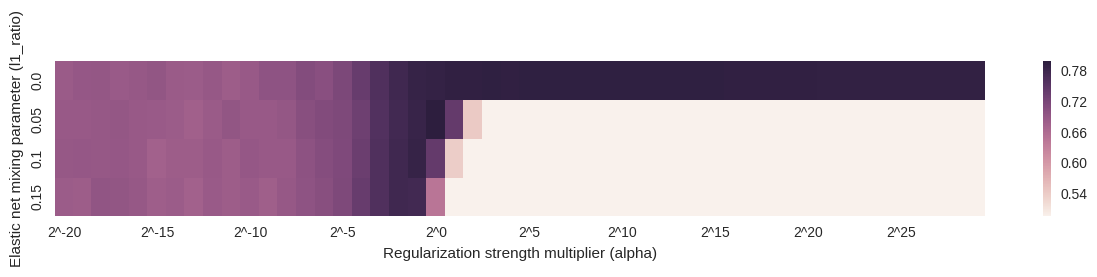

In [20]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_result_df, values='mean_test_score', index='l1_ratio', columns='alpha')
fig, ax = plt.subplots(figsize=(15,2))

xticks = ['2^'+str(x) for x in range(-20, 30)]
keptticks = xticks[::int(len(xticks)/10)]
xticks = ['' for y in xticks]
xticks[::int(len(xticks)/10)] = keptticks

ax = sns.heatmap(cv_score_mat, annot=False, fmt='.1%', xticklabels=xticks)
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)');

## Coefficients of the Classifier

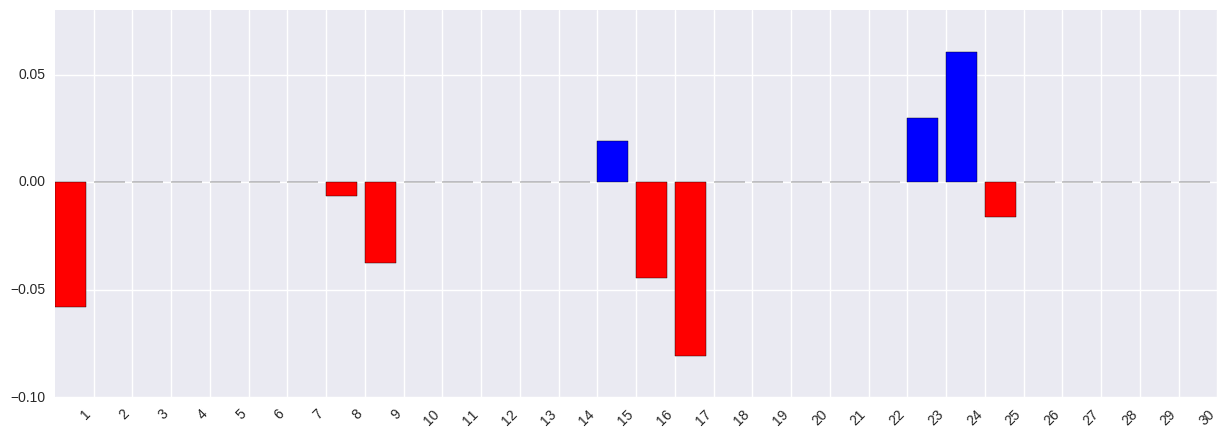

In [21]:
best_clf = cv.best_estimator_
coef = best_clf.coef_[0]
plt.figure(figsize = (15, 5))
colors = ["red" if coef[i] < 0 else "blue" for i in range(len(coef))]
plt.bar(np.arange(len(coef)), coef, color = colors)
plt.xticks(np.arange(1, len(coef)+1), rotation=45, ha="right");

## Use Optimal Hyperparameters to Output ROC Curve

In [22]:
y_pred_train = cv.decision_function(X_train_scale)
y_pred_test = cv.decision_function(X_test_scale)

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)

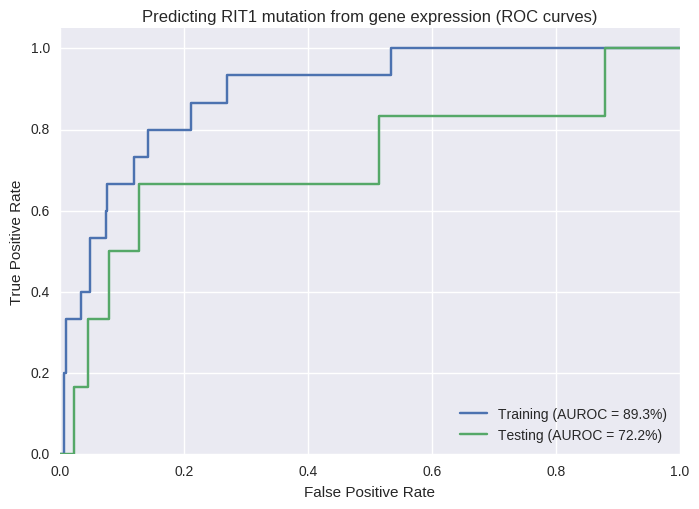

In [23]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting RIT1 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

## Investigate the predictions

In [24]:
X_transformed = scale_post.transform(pca.transform(scale_pre.transform(X)))

In [25]:
predict_df = pd.DataFrame.from_items([
    ('sample_id', X.index),
    ('testing', X.index.isin(X_test.index).astype(int)),
    ('status', y),
    ('decision_function', cv.decision_function(X_transformed)),
    ('probability', cv.predict_proba(X_transformed)[:, 1]),
])
predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [26]:
# Top predictions amongst negatives (potential hidden responders)
predict_df.sort_values('decision_function', ascending=False).query("status == 0").head(10)

,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-L9-A443-01,TCGA-L9-A443-01,0,0,1.034304,0.737749,73.8%
TCGA-55-7727-01,TCGA-55-7727-01,0,0,1.024156,0.735781,73.6%
TCGA-55-8506-01,TCGA-55-8506-01,1,0,1.021821,0.735327,73.5%
TCGA-62-A46R-01,TCGA-62-A46R-01,0,0,0.996704,0.730410,73.0%
TCGA-78-7535-01,TCGA-78-7535-01,0,0,0.995590,0.730191,73.0%
TCGA-62-A470-01,TCGA-62-A470-01,1,0,0.991142,0.729313,72.9%
TCGA-71-6725-01,TCGA-71-6725-01,0,0,0.987648,0.728623,72.9%
TCGA-L4-A4E5-01,TCGA-L4-A4E5-01,0,0,0.985936,0.728284,72.8%
TCGA-55-8514-01,TCGA-55-8514-01,0,0,0.984657,0.728031,72.8%


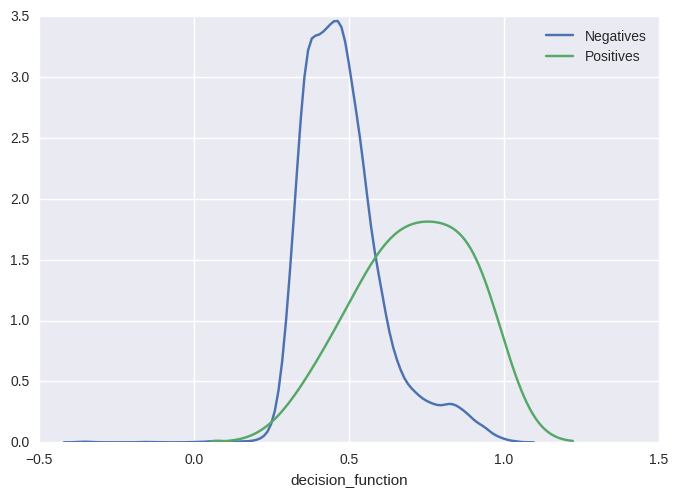

In [27]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

ax = sns.distplot(predict_df.query("status == 0").decision_function, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").decision_function, hist=False, label='Positives')

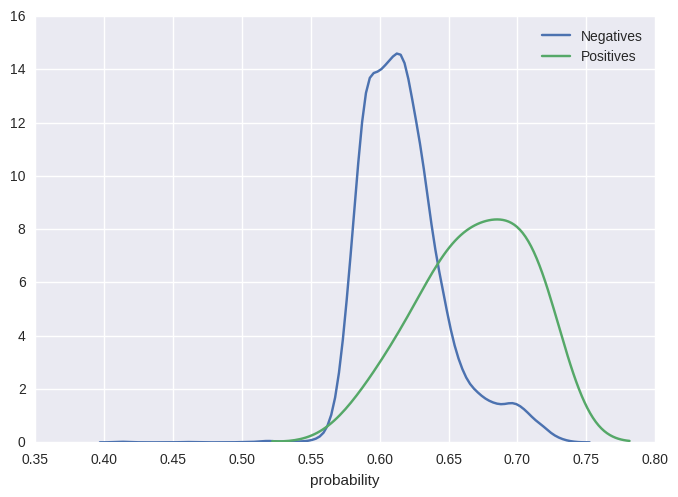

In [28]:
ax = sns.distplot(predict_df.query("status == 0").probability, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").probability, hist=False, label='Positives')